# Dependecies and Functions

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.express as px
import glob
import plotly.graph_objects as go
from scipy import stats
from scipy.optimize import curve_fit
from scipy import signal
from itertools import cycle

## Max projection function

In [2]:
# find_peak takes in an array -> input must be an array
# the input should be smoothed first with medfilt function
# the output of the function is array and a dict. I need an array with peaks -> find which of the peaks has higher value (and within 320 indices apart from soma) -> output the index as rcrit and value as NMax
# using this index then create a range +/- 80 indices to measure median and mean N from the original array
def peakNvalue(dfCol):
    # oriArray = dfCol['Intersection'].values
    smoothedArray = signal.medfilt(dfCol, 33)
    smoothedArray = np.insert(smoothedArray,0,0) # adding 0 padding in front of the curve to account for "flat" Sholl plots
    peaks = signal.find_peaks(smoothedArray,height=1,distance = 320)
    if peaks[0].size == 0:
        
        peak = float('nan')
        value = float('nan')
    else:
        peak = peaks[0][0]-1 # -1 to remove the padding
        value = peaks[1]["peak_heights"][0]
    
    cols=['r-crit','NMax']
    return pd.Series((peak,value),index=cols) #pd.DataFrame.from_dict({'r-crit':peak, 'NMax':value }) 
# indices = signal.find_peaks(div5sample)[0]
# peaks = pd.DataFrma(indices, columns=['Peak'])

# Loading rectified Sholl plot data

In [5]:
rectifiedSholl = pd.read_csv('./Exports4Paper/Mouse_matchedAAV.csv',low_memory=False)
rectifiedSholl

,Plate,Time,Region,Exp,Treatment,Neuron_Group,Length,Intersection
0,F,DIV7,ctx,147,BDNF,147-ctx-F-C7-0,0.00,4
1,F,DIV7,ctx,147,BDNF,147-ctx-F-C7-0,0.32,4
2,F,DIV7,ctx,147,BDNF,147-ctx-F-C7-0,0.64,4
3,F,DIV7,ctx,147,BDNF,147-ctx-F-C7-0,0.96,4
4,F,DIV7,ctx,147,BDNF,147-ctx-F-C7-0,1.28,4
...,...,...,...,...,...,...,...,...
138140,D,DIV5,ctx,157,Vehicle,157-ctx-D-U17-2,18.88,12
138141,D,DIV5,ctx,157,Vehicle,157-ctx-D-U17-2,19.20,12
138142,D,DIV5,ctx,157,Vehicle,157-ctx-D-U17-2,19.52,12
138143,D,DIV5,ctx,157,Vehicle,157-ctx-D-U17-2,19.84,11


## Average Sholl plots

### Aggregating data per condition

In [105]:
aggRectifiedSholl = rectifiedSholl.groupby(['Treatment','Time','Length'])['Intersection'].agg(
    Intersection='mean',
    SEM=lambda x: np.std(x) / np.sqrt(len(x))
).reset_index()
aggRectifiedSholl

,Treatment,Time,Length,Intersection,SEM
0,BDNF,DIV5,0.00,3.687500,0.304988
1,BDNF,DIV5,0.32,3.895833,0.309345
2,BDNF,DIV5,0.64,4.020833,0.320711
3,BDNF,DIV5,0.96,4.062500,0.296692
4,BDNF,DIV5,1.28,4.125000,0.288111
...,...,...,...,...,...
9370,Vehicle,DIV7,855.68,0.000000,0.000000
9371,Vehicle,DIV7,856.00,0.000000,0.000000
9372,Vehicle,DIV7,856.32,0.000000,0.000000
9373,Vehicle,DIV7,856.64,0.000000,0.000000


### Sholl plots

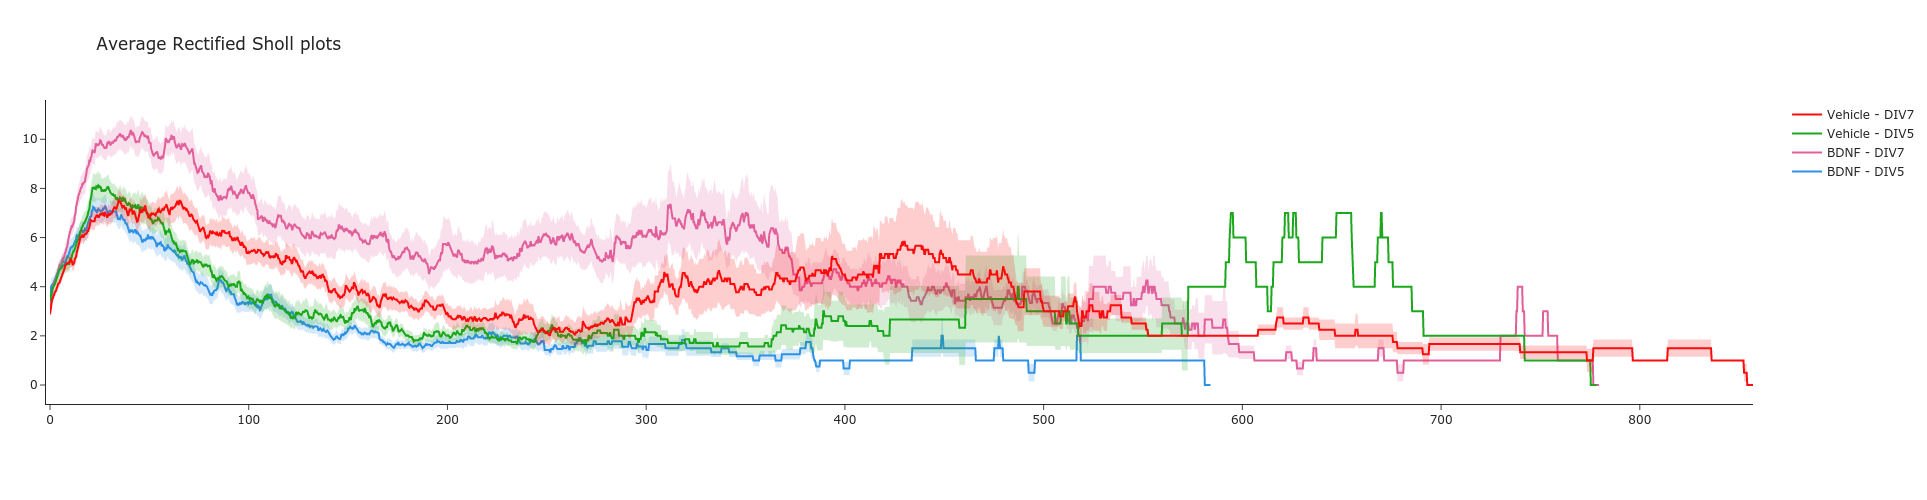

In [119]:
# function to generate color palette
def hex2rgba(x):
    if len(x) < 6:
        return tuple(17 * int(x[n+1], 16) * (1 if n < 3 else 1/255) for n in range(len(x) - 1))
    else:
        return tuple(int(x[2*n+1:2*n+3], 16) * (1 if n < 3 else 1/255) for n in range(len(x) // 2))


fig = go.Figure()

col_cycle = cycle(px.colors.qualitative.Dark24)


for treat in test['Treatment'].unique():
    for div in test['Time'].unique():

        color = next(col_cycle)
        test2 = test.loc[(test['Treatment']==treat)&(test['Time']==div)]
        fig.add_trace(
            go.Scatter(
               name=treat+' - '+div,
               x=test2['Length'],
               y=test2['Intersection'],
               mode='lines',
               line=dict(
                   color=color
               )
            ),            
        )
        fig.add_trace(
            go.Scatter(name='Upper Bound',
               x=test2['Length'],
               y=test2['Intersection'] + test2['SEM'],
               mode='lines',
               marker=dict(
                   color=color
               ),
               opacity=0.1,
               line=dict(
                   width=0
               ),
               showlegend=False
            )
        )
        fig.add_trace(
            go.Scatter(
               name='Lower Bound',
               x=test2['Length'],
               y=test2['Intersection'] - test2['SEM'],
               opacity=0.1,
               mode='lines',
               marker=dict(color=color),
               line=dict(width=0),
               fillcolor=f"rgba{(*hex2rgba(color), 0.2)}",
               fill='tonexty',
               showlegend=False
            )
        )

fig.update_layout(title="Average Rectified Sholl plots",
                  template="simple_white")

fig.update_layout(
    autosize=False,
    width=750,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

# Finding Max projections and data export for R analysis

In [113]:
# Finding peak values using custom function (see above)
shollPeak = rectifiedSholl.groupby(['Treatment','Time','Plate','Exp','Neuron_Group',])['Intersection'].apply(peakNvalue).unstack().reset_index()

# Exporting data for the analysis in R
shollPeak.to_csv('./Exports4Paper/Mouse_matchedAAV_perNeuron_PeakValues.csv')

shollPeak

,Treatment,Time,Plate,Exp,Neuron_Group,r-crit,NMax
0,BDNF,DIV5,A,147,147-ctx-A-14right-0,94.0,5.0
1,BDNF,DIV5,A,147,147-ctx-A-9right-0,94.0,7.0
2,BDNF,DIV5,A,147,147-ctx-A-N2-0,178.0,6.0
3,BDNF,DIV5,A,147,147-ctx-A-N2-1,107.0,4.0
4,BDNF,DIV5,A,147,147-ctx-A-P6-0,149.0,5.0
...,...,...,...,...,...,...,...
187,Vehicle,DIV7,D,157,157-ctx-D-O19-1,199.0,9.0
188,Vehicle,DIV7,D,157,157-ctx-D-U11-0,12.0,6.0
189,Vehicle,DIV7,D,157,157-ctx-D-U17-0,178.0,4.0
190,Vehicle,DIV7,D,157,157-ctx-D-U17-1,188.0,7.0
